In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score, 
    recall_score, f1_score, classification_report,
    RocCurveDisplay, PrecisionRecallDisplay, confusion_matrix
)
from sklearn.calibration import calibration_curve

import warnings
warnings.filterwarnings('ignore')

# Фиксируем random_state для воспроизводимости
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [10]:
df = pd.read_csv('S05-hw-dataset.csv')
print("Форма датасета:", df.shape)
print("\nПервые 5 строк датасета:")
display(df.head())

Форма датасета: (3000, 17)

Первые 5 строк датасета:


,client_id,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years,default
0,1,25,94074,22,839,0.547339,1,7,0,0,26057,5229,0.080052,19,1,8,0
1,2,58,51884,26,565,0.290882,1,1,0,1,16221,11595,0.428311,15,0,7,0
2,3,53,48656,39,561,0.522340,1,13,0,0,55448,-2947,0.770883,15,4,5,0
3,4,42,81492,30,582,0.709123,2,10,1,1,35188,17727,0.357619,0,2,7,1
4,5,42,94713,8,642,0.793392,3,3,0,0,0,-404,0.414260,17,1,10,1


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   client_id                       3000 non-null   int64  
 1   age                             3000 non-null   int64  
 2   income                          3000 non-null   int64  
 3   years_employed                  3000 non-null   int64  
 4   credit_score                    3000 non-null   int64  
 5   debt_to_income                  3000 non-null   float64
 6   num_credit_cards                3000 non-null   int64  
 7   num_late_payments               3000 non-null   int64  
 8   has_mortgage                    3000 non-null   int64  
 9   has_car_loan                    3000 non-null   int64  
 10  savings_balance                 3000 non-null   int64  
 11  checking_balance                3000 non-null   int64  
 12  region_risk_score               30

In [12]:
display(df.describe())

,client_id,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years,default
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,1500.500000,45.059667,69658.992000,19.577667,649.285333,0.284065,3.494667,6.869333,0.495000,0.501333,20607.256667,5559.684333,0.400175,9.524667,1.976333,6.968667,0.410333
std,866.169729,14.192883,24742.235182,11.381497,69.955852,0.161112,2.289917,4.291278,0.500058,0.500082,14035.209739,6306.032612,0.204529,5.779030,1.408700,4.349942,0.491976
min,1.000000,21.000000,15000.000000,0.000000,402.000000,0.006147,0.000000,0.000000,0.000000,0.000000,0.000000,-3000.000000,0.001148,0.000000,0.000000,0.000000,0.000000
25%,750.750000,33.000000,52641.750000,10.000000,604.000000,0.157796,1.000000,3.000000,0.000000,0.000000,9612.250000,341.500000,0.239208,5.000000,1.000000,3.000000,0.000000
50%,1500.500000,45.000000,69784.500000,20.000000,647.000000,0.261726,3.000000,7.000000,0.000000,1.000000,20021.000000,5114.500000,0.381992,10.000000,2.000000,7.000000,0.000000
75%,2250.250000,57.000000,85874.250000,29.000000,697.000000,0.388886,6.000000,10.000000,1.000000,1.000000,30101.250000,9906.250000,0.549213,15.000000,3.000000,11.000000,1.000000
max,3000.000000,69.000000,156351.000000,39.000000,850.000000,0.878343,7.000000,14.000000,1.000000,1.000000,75237.000000,29335.000000,0.961733,19.000000,4.000000,14.000000,1.000000


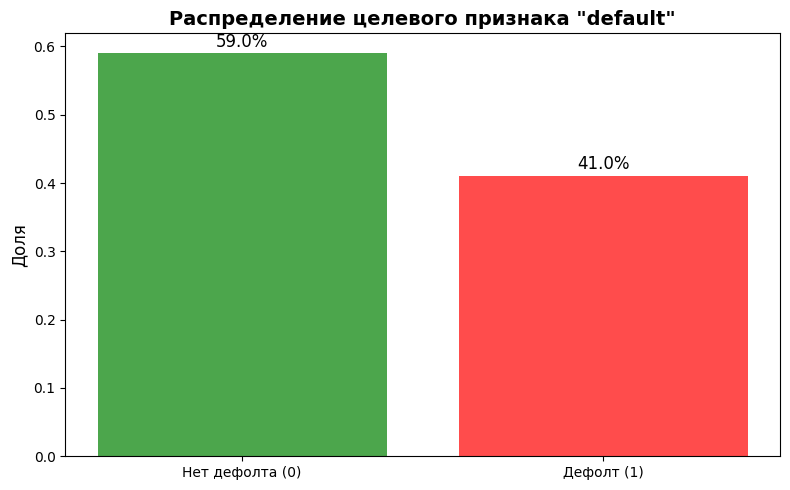

In [13]:
default_distribution = df['default'].value_counts(normalize=True)
# Визуализация распределения
plt.figure(figsize=(8, 5))
bars = plt.bar(['Нет дефолта (0)', 'Дефолт (1)'], 
               default_distribution.values, 
               color=['green', 'red'], alpha=0.7)
plt.title('Распределение целевого признака "default"', fontsize=14, fontweight='bold')
plt.ylabel('Доля', fontsize=12)

# Добавляем проценты на столбцы
for i, (label, value) in enumerate(default_distribution.items()):
    plt.text(i, value + 0.01, f'{value:.1%}', ha='center', fontsize=12)

plt.tight_layout()
plt.savefig('figures/default_distribution.png', dpi=100, bbox_inches='tight')
plt.show()

In [14]:
print("Проверка пропущенных значений:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

Проверка пропущенных значений:
Series([], dtype: int64)


Корреляция признаков с целевой переменной:
default                           1.000000
debt_to_income                    0.383239
num_late_payments                 0.281268
region_risk_score                 0.225104
active_loans                      0.192997
has_car_loan                      0.121786
has_mortgage                      0.101185
client_id                         0.032691
checking_balance                  0.027769
phone_calls_to_support_last_3m    0.027342
age                               0.025813
savings_balance                   0.012065
years_employed                    0.005829
income                            0.001395
customer_tenure_years            -0.015804
num_credit_cards                 -0.026323
credit_score                     -0.216288
Name: default, dtype: float64


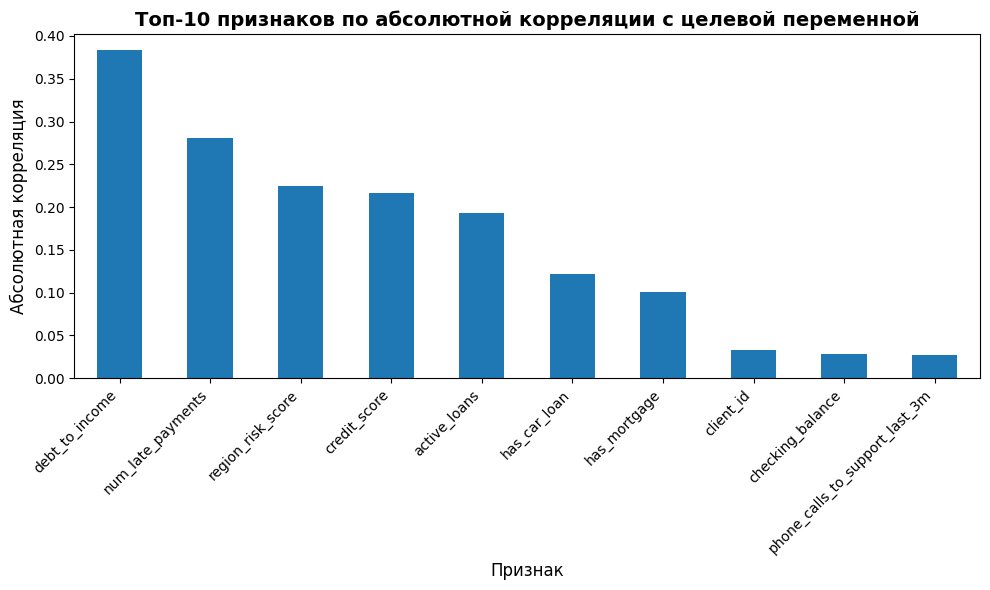

In [15]:
# Вычисляем корреляции
correlations = df.corr()['default'].sort_values(ascending=False)
print("Корреляция признаков с целевой переменной:")
print(correlations)

# Визуализация топ-10 корреляций
plt.figure(figsize=(10, 6))
correlations.abs().sort_values(ascending=False).head(11)[1:].plot(kind='bar')
plt.title('Топ-10 признаков по абсолютной корреляции с целевой переменной', fontsize=14, fontweight='bold')
plt.xlabel('Признак', fontsize=12)
plt.ylabel('Абсолютная корреляция', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('figures/top_correlations.png', dpi=100, bbox_inches='tight')
plt.show()

In [16]:
X = df.drop(['default', 'client_id'], axis=1)
y = df['default']

print(f"Размерность X: {X.shape}")
print(f"Размерность y: {y.shape}")
print(f"\nКоличество признаков: {X.shape[1]}")
print(f"Названия признаков: {list(X.columns)}")

Размерность X: (3000, 15)
Размерность y: (3000,)

Количество признаков: 15
Названия признаков: ['age', 'income', 'years_employed', 'credit_score', 'debt_to_income', 'num_credit_cards', 'num_late_payments', 'has_mortgage', 'has_car_loan', 'savings_balance', 'checking_balance', 'region_risk_score', 'phone_calls_to_support_last_3m', 'active_loans', 'customer_tenure_years']


In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y,  # сохраняем распределение классов
    random_state=RANDOM_STATE
)

print("Размеры выборок:")
print(f"  Обучающая выборка (train): {X_train.shape}")
print(f"  Тестовая выборка (test): {X_test.shape}")

print("\nРаспределение классов в выборках:")
print(f"  Train: {y_train.value_counts(normalize=True).values}")
print(f"  Test: {y_test.value_counts(normalize=True).values}")

Размеры выборок:
  Обучающая выборка (train): (2400, 15)
  Тестовая выборка (test): (600, 15)

Распределение классов в выборках:
  Train: [0.58958333 0.41041667]
  Test: [0.59 0.41]


In [18]:
baseline = DummyClassifier(strategy='stratified', random_state=RANDOM_STATE)
baseline.fit(X_train, y_train)

# Предсказания на тестовой выборке
y_pred_baseline = baseline.predict(X_test)
y_proba_baseline = baseline.predict_proba(X_test)[:, 1]

# Вычисляем метрики
accuracy_baseline = accuracy_score(y_test, y_pred_baseline)
roc_auc_baseline = roc_auc_score(y_test, y_proba_baseline)
precision_baseline = precision_score(y_test, y_pred_baseline)
recall_baseline = recall_score(y_test, y_pred_baseline)
f1_baseline = f1_score(y_test, y_pred_baseline)

print("(DummyClassifier, strategy='stratified')")
print(f"Accuracy: {accuracy_baseline:.4f}")
print(f"ROC-AUC: {roc_auc_baseline:.4f}")
print(f"Precision: {precision_baseline:.4f}")
print(f"Recall: {recall_baseline:.4f}")
print(f"F1-Score: {f1_baseline:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_baseline, target_names=['No Default', 'Default']))

(DummyClassifier, strategy='stratified')
Accuracy: 0.5133
ROC-AUC: 0.5008
Precision: 0.4109
Recall: 0.4309
F1-Score: 0.4206

Classification Report:
              precision    recall  f1-score   support

  No Default       0.59      0.57      0.58       354
     Default       0.41      0.43      0.42       246

    accuracy                           0.51       600
   macro avg       0.50      0.50      0.50       600
weighted avg       0.52      0.51      0.51       600



Бейзлайн-модель предсказывает классы случайным образом, но сохраняя распределение классов из обучающей выборки. Это дает нам нижнюю планку качества - любая осмысленная модель должна превосходить эти показатели. В нашем случае accuracy около 0.5 - это ожидаемый результат для случайного угадывания в бинарной классификации.

In [19]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(
        max_iter=1000,
        random_state=RANDOM_STATE,
        class_weight='balanced'  # учитываем дисбаланс классов
    ))
])

In [20]:
param_grid = {
    'logreg__C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],  # сила регуляризации
    'logreg__penalty': ['l2'],  # можно добавить 'l1', но потребуется другой solver
    'logreg__solver': ['liblinear', 'lbfgs']
}

In [21]:
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,  # 5-fold кросс-валидация
    scoring='roc_auc',  # оптимизируем по ROC-AUC
    n_jobs=-1,  # используем все доступные ядра
    verbose=1
)

In [22]:
print("Запуск GridSearchCV...")
grid_search.fit(X_train, y_train)

print("\nЛучшие параметры:", grid_search.best_params_)
print(f"Лучший ROC-AUC (кросс-валидация): {grid_search.best_score_:.4f}")

Запуск GridSearchCV...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Лучшие параметры: {'logreg__C': 0.1, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}
Лучший ROC-AUC (кросс-валидация): 0.8606


In [23]:
best_model = grid_search.best_estimator_

# Предсказания на тестовой выборке
y_pred_lr = best_model.predict(X_test)
y_proba_lr = best_model.predict_proba(X_test)[:, 1]

# Вычисляем метрики
accuracy_lr = accuracy_score(y_test, y_pred_lr)
roc_auc_lr = roc_auc_score(y_test, y_proba_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

print("=== Лучшая модель логистической регрессии ===")
print(f"Accuracy: {accuracy_lr:.4f}")
print(f"ROC-AUC: {roc_auc_lr:.4f}")
print(f"Precision: {precision_lr:.4f}")
print(f"Recall: {recall_lr:.4f}")
print(f"F1-Score: {f1_lr:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['No Default', 'Default']))

=== Лучшая модель логистической регрессии ===
Accuracy: 0.7983
ROC-AUC: 0.8752
Precision: 0.7490
Recall: 0.7642
F1-Score: 0.7565

Classification Report:
              precision    recall  f1-score   support

  No Default       0.83      0.82      0.83       354
     Default       0.75      0.76      0.76       246

    accuracy                           0.80       600
   macro avg       0.79      0.79      0.79       600
weighted avg       0.80      0.80      0.80       600



In [24]:
# Создаем таблицу сравнения
comparison_df = pd.DataFrame({
    'Метрика': ['Accuracy', 'ROC-AUC', 'Precision', 'Recall', 'F1-Score'],
    'Бейзлайн': [
        f"{accuracy_baseline:.4f}", 
        f"{roc_auc_baseline:.4f}", 
        f"{precision_baseline:.4f}", 
        f"{recall_baseline:.4f}", 
        f"{f1_baseline:.4f}"
    ],
    'Логистическая регрессия': [
        f"{accuracy_lr:.4f}", 
        f"{roc_auc_lr:.4f}", 
        f"{precision_lr:.4f}", 
        f"{recall_lr:.4f}", 
        f"{f1_lr:.4f}"
    ],
    'Улучшение (абсолютное)': [
        f"{accuracy_lr - accuracy_baseline:.4f}",
        f"{roc_auc_lr - roc_auc_baseline:.4f}",
        f"{precision_lr - precision_baseline:.4f}",
        f"{recall_lr - recall_baseline:.4f}",
        f"{f1_lr - f1_baseline:.4f}"
    ],
    'Улучшение (относительное)': [
        f"{(accuracy_lr - accuracy_baseline) / accuracy_baseline * 100:.1f}%",
        f"{(roc_auc_lr - roc_auc_baseline) / roc_auc_baseline * 100:.1f}%",
        f"{(precision_lr - precision_baseline) / precision_baseline * 100:.1f}%" if precision_baseline > 0 else "N/A",
        f"{(recall_lr - recall_baseline) / recall_baseline * 100:.1f}%",
        f"{(f1_lr - f1_baseline) / f1_baseline * 100:.1f}%"
    ]
})

print("Сравнение моделей:")
display(comparison_df)

Сравнение моделей:


,Метрика,Бейзлайн,Логистическая регрессия,Улучшение (абсолютное),Улучшение (относительное)
0,Accuracy,0.5133,0.7983,0.2850,55.5%
1,ROC-AUC,0.5008,0.8752,0.3745,74.8%
2,Precision,0.4109,0.7490,0.3382,82.3%
3,Recall,0.4309,0.7642,0.3333,77.4%
4,F1-Score,0.4206,0.7565,0.3359,79.9%


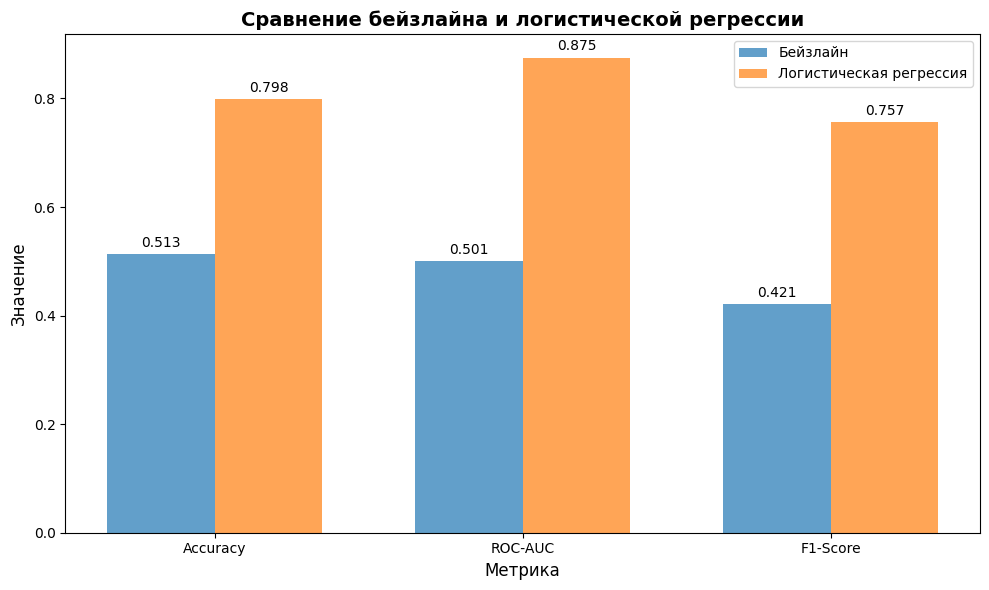

In [25]:
# Визуализация сравнения
metrics = ['Accuracy', 'ROC-AUC', 'F1-Score']
baseline_scores = [accuracy_baseline, roc_auc_baseline, f1_baseline]
lr_scores = [accuracy_lr, roc_auc_lr, f1_lr]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, baseline_scores, width, label='Бейзлайн', alpha=0.7)
bars2 = ax.bar(x + width/2, lr_scores, width, label='Логистическая регрессия', alpha=0.7)

ax.set_xlabel('Метрика', fontsize=12)
ax.set_ylabel('Значение', fontsize=12)
ax.set_title('Сравнение бейзлайна и логистической регрессии', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Добавляем значения на столбцы
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                   xy=(bar.get_x() + bar.get_width() / 2, height),
                   xytext=(0, 3),
                   textcoords="offset points",
                   ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('figures/model_comparison.png', dpi=100, bbox_inches='tight')
plt.show()

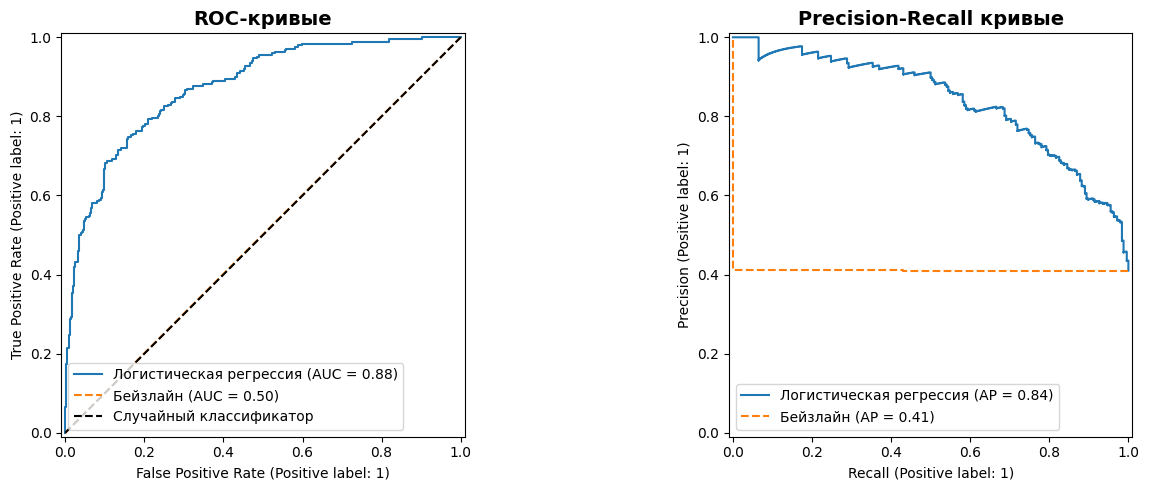

In [26]:
# ROC-кривая
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# ROC-кривая
RocCurveDisplay.from_predictions(
    y_test, y_proba_lr,
    ax=ax1,
    name='Логистическая регрессия'
)
RocCurveDisplay.from_predictions(
    y_test, y_proba_baseline,
    ax=ax1,
    name='Бейзлайн',
    linestyle='--'
)
ax1.set_title('ROC-кривые', fontsize=14, fontweight='bold')
ax1.plot([0, 1], [0, 1], 'k--', label='Случайный классификатор')
ax1.legend()

# PR-кривая
PrecisionRecallDisplay.from_predictions(
    y_test, y_proba_lr,
    ax=ax2,
    name='Логистическая регрессия'
)
PrecisionRecallDisplay.from_predictions(
    y_test, y_proba_baseline,
    ax=ax2,
    name='Бейзлайн',
    linestyle='--'
)
ax2.set_title('Precision-Recall кривые', fontsize=14, fontweight='bold')
ax2.legend()

plt.tight_layout()
plt.savefig('figures/RocPrecisionFigures.png', dpi=100, bbox_inches='tight')
plt.show()

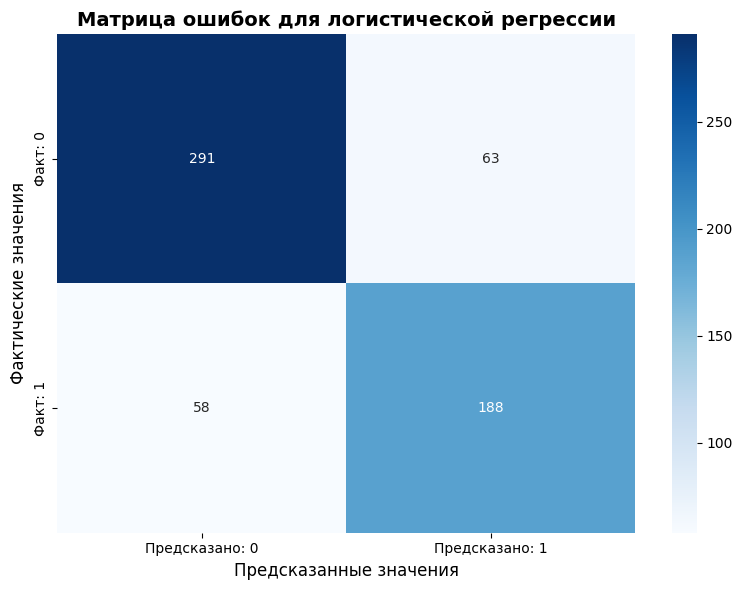

In [27]:
cm = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Предсказано: 0', 'Предсказано: 1'],
            yticklabels=['Факт: 0', 'Факт: 1'])
plt.title('Матрица ошибок для логистической регрессии', fontsize=14, fontweight='bold')
plt.ylabel('Фактические значения', fontsize=12)
plt.xlabel('Предсказанные значения', fontsize=12)
plt.tight_layout()
plt.savefig('figures/confusion_matrix.png', dpi=100, bbox_inches='tight')
plt.show()


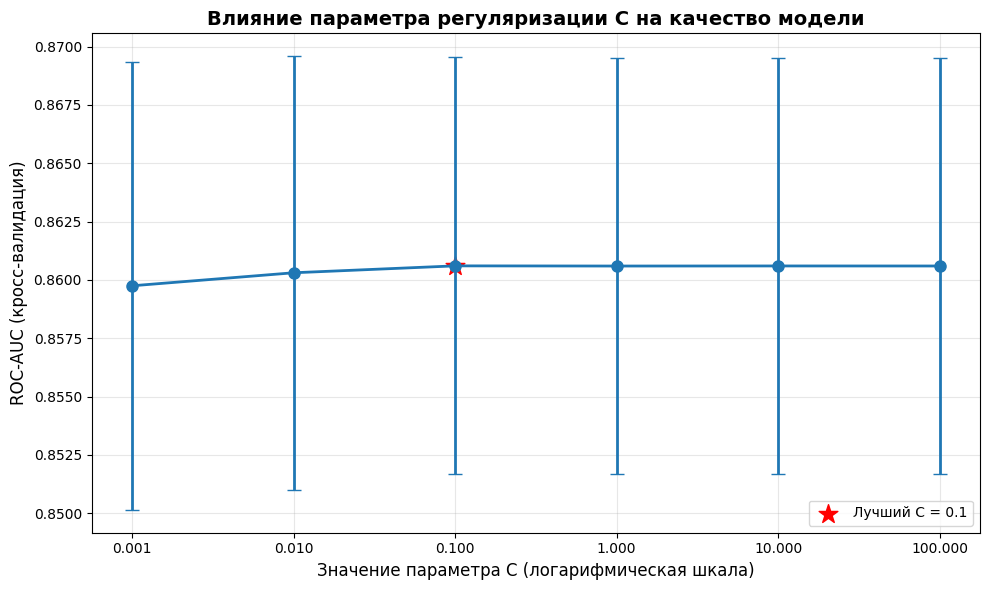

In [28]:
results_df = pd.DataFrame(grid_search.cv_results_)
c_values = param_grid['logreg__C']

# Извлекаем средние значения ROC-AUC для разных значений C
mean_scores = []
std_scores = []

for c in c_values:
    mask = results_df['param_logreg__C'] == c
    mean_scores.append(results_df[mask]['mean_test_score'].mean())
    std_scores.append(results_df[mask]['std_test_score'].mean())

# Визуализация
plt.figure(figsize=(10, 6))
plt.errorbar(range(len(c_values)), mean_scores, yerr=std_scores, 
             fmt='o-', capsize=5, linewidth=2, markersize=8)
plt.xlabel('Значение параметра C (логарифмическая шкала)', fontsize=12)
plt.ylabel('ROC-AUC (кросс-валидация)', fontsize=12)
plt.title('Влияние параметра регуляризации C на качество модели', fontsize=14, fontweight='bold')
plt.xticks(range(len(c_values)), [f'{c:.3f}' for c in c_values])
plt.grid(True, alpha=0.3)

# Помечаем лучший параметр
best_c = grid_search.best_params_['logreg__C']
best_idx = list(c_values).index(best_c)
plt.scatter(best_idx, mean_scores[best_idx], color='red', s=200, 
            marker='*', label=f'Лучший C = {best_c}')
plt.legend()

plt.tight_layout()
plt.savefig('figures/best_c.png', dpi=100, bbox_inches='tight')
plt.show()

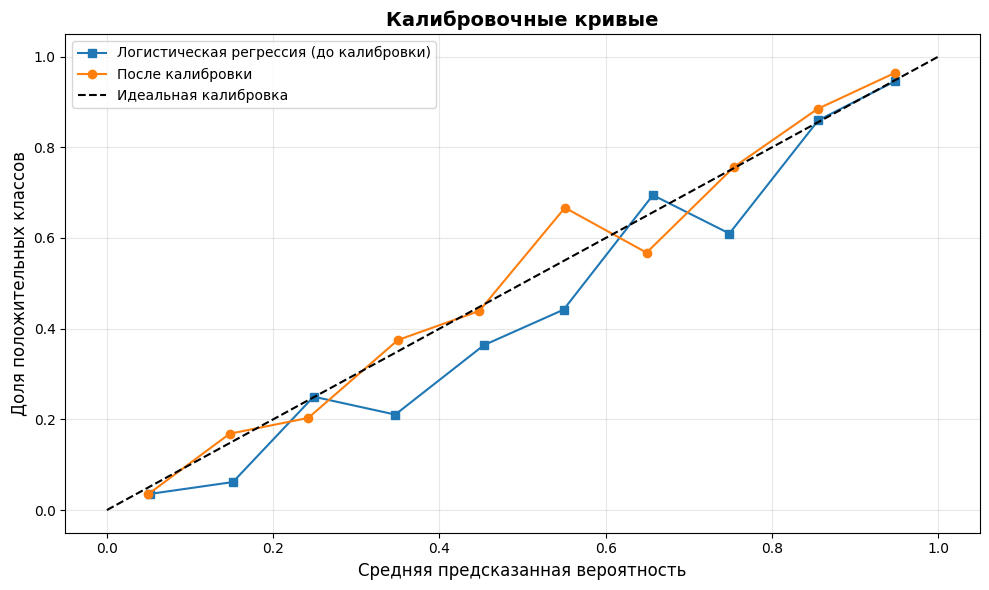

In [29]:
from sklearn.calibration import CalibratedClassifierCV

# Создаем калиброванную модель
calibrated_model = CalibratedClassifierCV(
    best_model,
    method='sigmoid',
    cv=5
)

calibrated_model.fit(X_train, y_train)
y_proba_calibrated = calibrated_model.predict_proba(X_test)[:, 1]

# Сравнение калибровочных кривых
prob_true_lr, prob_pred_lr = calibration_curve(y_test, y_proba_lr, n_bins=10)
prob_true_cal, prob_pred_cal = calibration_curve(y_test, y_proba_calibrated, n_bins=10)

plt.figure(figsize=(10, 6))
plt.plot(prob_pred_lr, prob_true_lr, 's-', label='Логистическая регрессия (до калибровки)')
plt.plot(prob_pred_cal, prob_true_cal, 'o-', label='После калибровки')
plt.plot([0, 1], [0, 1], 'k--', label='Идеальная калибровка')
plt.xlabel('Средняя предсказанная вероятность', fontsize=12)
plt.ylabel('Доля положительных классов', fontsize=12)
plt.title('Калибровочные кривые', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/calibrated_model.png', dpi=100, bbox_inches='tight')
plt.show()

## Итоговые комментарии

1. ОБЗОР ДАННЫХ:
   - Датасет содержит 3000 наблюдений и 17 признаков
   - Целевая переменная 'default' имеет умеренный дисбаланс: 59.0% без дефолта vs 41.0% с дефолтом

2. СРАВНЕНИЕ МОДЕЛЕЙ:
   - Бейзлайн (DummyClassifier): Accuracy = 0.5133, ROC-AUC = 0.5008
   - Логистическая регрессия: Accuracy = 0.7983, ROC-AUC = 0.8752
   - Улучшение ROC-AUC: 0.3745 (относительно 74.8%)

3. ИТОГОВАЯ ОЦЕНКА:
   - Логистическая регрессия значительно превосходит бейзлайн по всем метрикам
   - ROC-AUC = 0.8752 указывает на хорошую разделяющую способность модели
   - F1-score = 0.7565 демонстрирует баланс между precision и recall
   - Модель хорошо справляется с обнаружением дефолтов (recall = 0.7642)
   - Наилучшие гиперпараметры: C = 0.1, solver = liblinear

4. ВЫВОДЫ:
   - Логистическая регрессия показала себя как эффективная модель для задачи прогнозирования дефолта
   - Модель успешно преодолела проблему дисбаланса классов
   - Результаты могут быть улучшены за счет использования более сложных моделей